In [10]:
!pip install optuna
!pip install tqdm
!pip install feature-engine
!pip install scikit-learn
!pip install lightgbm
!pip install --upgrade scikit-learn
!pip install --upgrade <cyclical-features-library>


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The syntax of the command is incorrect.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from feature_engine.creation import CyclicalFeatures
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Loading the Data

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sample_submission = pd.read_csv('./sample_submission.csv')

Data Preprocessing
-> Clean the data by adding the mean value to the fields where it is missing or a random value where the mean can t be calculated
-> dropping the id column

In [6]:

mean_age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_age)
test['Age'] = test['Age'].fillna(mean_age)

median_annual_income = train['Annual Income'].median()
train['Annual Income'] = train['Annual Income'].fillna(median_annual_income)
test['Annual Income'] = test['Annual Income'].fillna(median_annual_income)

train['Marital Status'] = train['Marital Status'].fillna(np.random.choice(['Single', 'Married', 'Divorced']))
test['Marital Status'] = test['Marital Status'].fillna(np.random.choice(['Single', 'Married', 'Divorced']))

mean_number_dependents = train['Number of Dependents'].mean()
train['Number of Dependents'] = train['Number of Dependents'].fillna(mean_number_dependents)
test['Number of Dependents'] = test['Number of Dependents'].fillna(mean_number_dependents)

train['Occupation'] = train['Occupation'].fillna('Missing')
test['Occupation'] = test['Occupation'].fillna('Missing')

mean_health_score = train['Health Score'].mean()
train['Health Score'] = train['Health Score'].fillna(mean_health_score)
test['Health Score'] = test['Health Score'].fillna(mean_health_score)

median_previous_claims = train['Previous Claims'].median()
train['Previous Claims'] = train['Previous Claims'].fillna(median_previous_claims)
test['Previous Claims'] = test['Previous Claims'].fillna(median_previous_claims)

mean_vehicle_age = train['Vehicle Age'].mean()
train['Vehicle Age'] = train['Vehicle Age'].fillna(mean_vehicle_age)
test['Vehicle Age'] = test['Vehicle Age'].fillna(mean_vehicle_age)

mean_credit_score = train['Credit Score'].mean()
train['Credit Score'] = train['Credit Score'].fillna(mean_credit_score)
test['Credit Score'] = test['Credit Score'].fillna(mean_credit_score)

mean_insurance_duration = train['Insurance Duration'].mean()
train['Insurance Duration'] = train['Insurance Duration'].fillna(mean_insurance_duration)
test['Insurance Duration'] = test['Insurance Duration'].fillna(mean_insurance_duration)

train['Customer Feedback'] = train['Customer Feedback'].fillna(np.random.choice(['Poor', 'Average', 'Good']))
test['Customer Feedback'] = test['Customer Feedback'].fillna(np.random.choice(['Poor', 'Average', 'Good']))

train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [13]:
#Cycling dates
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])

# Cyclical encoding of the year - no need for cos and sinus interpretations
train['Year'] = train['Policy Start Date'].dt.year
test['Year'] = test['Policy Start Date'].dt.year

train['Month'] = train['Policy Start Date'].dt.month
test['Month'] = test['Policy Start Date'].dt.month

train['Month_cos'] = np.cos(2 * np.pi * train['Month'] / 12)
train['Month_sin'] = np.sin(2 * np.pi * train['Month'] / 12)

test['Month_cos'] = np.cos(2 * np.pi * test['Month'] / 12)
test['Month_sin'] = np.sin(2 * np.pi * test['Month'] / 12)

train['Day'] = train['Policy Start Date'].dt.day
test['Day'] = test['Policy Start Date'].dt.day

train['Day_cos'] = np.cos(2 * np.pi * train['Day'] / 31)
train['Day_sin'] = np.sin(2 * np.pi * train['Day'] / 31)

test['Day_cos'] = np.cos(2 * np.pi * test['Day'] / 31)
test['Day_sin'] = np.sin(2 * np.pi * test['Day'] / 31)

train.drop(columns=['Day','Month','Policy Start Date'], inplace=True)
test.drop(columns=['Day','Month','Policy Start Date' ], inplace=True)

In [14]:
#encoding the categorical columns
le = LabelEncoder()

for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

In [15]:
y = train['Premium Amount']
X = train.drop(columns=['Premium Amount'])

In [ ]:
# def rmsLe(y_true, y_pred):
#     y_pred = np.maximum(y_pred, 1e-6)
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

# SEED = 42
# n_splits = 5

# def TrainML(params, e_stop=50):
#     kfold = RepeatedKFold(n_splits=n_splits, n_repeats=1, random_state=SEED)
#     train_rmse_scores = []
#     val_rmse_scores = []

#     for fold, (train_idx, val_idx) in enumerate(tqdm(kfold.split(X, y), desc="Training Folds", total=n_splits)):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         y_train_log = np.log1p(y_train)
#         y_val_log = np.log1p(y_val)
        
#         callbacks = [lgb.early_stopping(stopping_rounds=e_stop, verbose=False)]
#         model = lgb.LGBMRegressor(**params, random_state=SEED, verbose=-1, n_jobs=-1)
#         model.fit(X_train, y_train_log, 
#                   eval_set=[(X_val, y_val_log)], 
#                   eval_metric='rmse', 
#                   callbacks=callbacks)
        
#         y_train_log_pred = model.predict(X_train)
#         y_val_log_pred = model.predict(X_val)
        
#         y_train_pred = np.expm1(y_train_log_pred)
#         y_val_pred = np.expm1(y_val_log_pred)
        
#         train_rmse = rmsLe(y_train, y_train_pred)
#         val_rmse = rmsLe(y_val, y_val_pred)

#         train_rmse_scores.append(train_rmse)
#         val_rmse_scores.append(val_rmse)

#     mean_train_rmse = np.mean(train_rmse_scores)
#     mean_val_rmse = np.mean(val_rmse_scores)

#     print("\n Final Mean Scores:")
#     print(f" Mean Train RMSLE: {mean_train_rmse:.4f}")
#     print(f" Mean Validation RMSLE: {mean_val_rmse:.4f}")

#     return mean_train_rmse, mean_val_rmse

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
#         'device': 'gpu'
#     }

#     mean_train_rmse, mean_val_rmse = TrainML(params)
#     trial.set_user_attr('train_rmse', mean_train_rmse)
#     trial.set_user_attr('val_rmse', mean_val_rmse)
#     return mean_val_rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=5)


[I 2024-12-11 18:28:51,236] A new study created in memory with name: no-name-93320a83-24fb-4498-9620-a2b1a7594d10


🚀 Starting hyperparameter tuning...


Training Folds: 100%|██████████| 5/5 [02:21<00:00, 28.33s/it]
[I 2024-12-11 18:31:12,953] Trial 0 finished with value: 1.0517984550755946 and parameters: {'n_estimators': 250, 'learning_rate': 0.08580733050021148, 'num_leaves': 101, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.7134478663376426, 'colsample_bytree': 0.8784850673485076, 'reg_alpha': 0.29527575800940653, 'reg_lambda': 0.0017685437792625232}. Best is trial 0 with value: 1.0517984550755946.



🎯 Final Mean Scores:
🏋️‍♂️ Mean Train RMSLE: 1.0439
🧪 Mean Validation RMSLE: 1.0518


Training Folds: 100%|██████████| 5/5 [02:55<00:00, 35.12s/it]
[I 2024-12-11 18:34:08,602] Trial 1 finished with value: 1.051662062267189 and parameters: {'n_estimators': 850, 'learning_rate': 0.04808485610008869, 'num_leaves': 64, 'max_depth': 13, 'min_child_samples': 43, 'subsample': 0.8692990538466672, 'colsample_bytree': 0.9616615987382207, 'reg_alpha': 0.3684495539610594, 'reg_lambda': 1.6216744700880563}. Best is trial 1 with value: 1.051662062267189.



🎯 Final Mean Scores:
🏋️‍♂️ Mean Train RMSLE: 1.0452
🧪 Mean Validation RMSLE: 1.0517


Training Folds: 100%|██████████| 5/5 [06:51<00:00, 82.34s/it]
[I 2024-12-11 18:41:00,328] Trial 2 finished with value: 1.0531951265717996 and parameters: {'n_estimators': 700, 'learning_rate': 0.006002641114390338, 'num_leaves': 42, 'max_depth': 15, 'min_child_samples': 72, 'subsample': 0.7200344333898133, 'colsample_bytree': 0.6986521753741868, 'reg_alpha': 0.0013223748424590466, 'reg_lambda': 0.40630468090624405}. Best is trial 1 with value: 1.051662062267189.



🎯 Final Mean Scores:
🏋️‍♂️ Mean Train RMSLE: 1.0520
🧪 Mean Validation RMSLE: 1.0532


Training Folds: 100%|██████████| 5/5 [16:33<00:00, 198.79s/it]
[I 2024-12-11 18:57:34,327] Trial 3 finished with value: 1.0518343567350603 and parameters: {'n_estimators': 600, 'learning_rate': 0.12518542893418058, 'num_leaves': 94, 'max_depth': 12, 'min_child_samples': 36, 'subsample': 0.5345504808929469, 'colsample_bytree': 0.8063320428719022, 'reg_alpha': 0.14074698474693484, 'reg_lambda': 0.01216614352919742}. Best is trial 1 with value: 1.051662062267189.



🎯 Final Mean Scores:
🏋️‍♂️ Mean Train RMSLE: 1.0459
🧪 Mean Validation RMSLE: 1.0518


Training Folds: 100%|██████████| 5/5 [01:42<00:00, 20.46s/it]
[I 2024-12-11 18:59:16,685] Trial 4 finished with value: 1.0517251850666804 and parameters: {'n_estimators': 1000, 'learning_rate': 0.09414028109411066, 'num_leaves': 61, 'max_depth': 13, 'min_child_samples': 92, 'subsample': 0.7155392349184961, 'colsample_bytree': 0.9065745143943389, 'reg_alpha': 0.05409413395560231, 'reg_lambda': 0.00032762848665065543}. Best is trial 1 with value: 1.051662062267189.



🎯 Final Mean Scores:
🏋️‍♂️ Mean Train RMSLE: 1.0464
🧪 Mean Validation RMSLE: 1.0517
✅ Hyperparameter tuning completed!


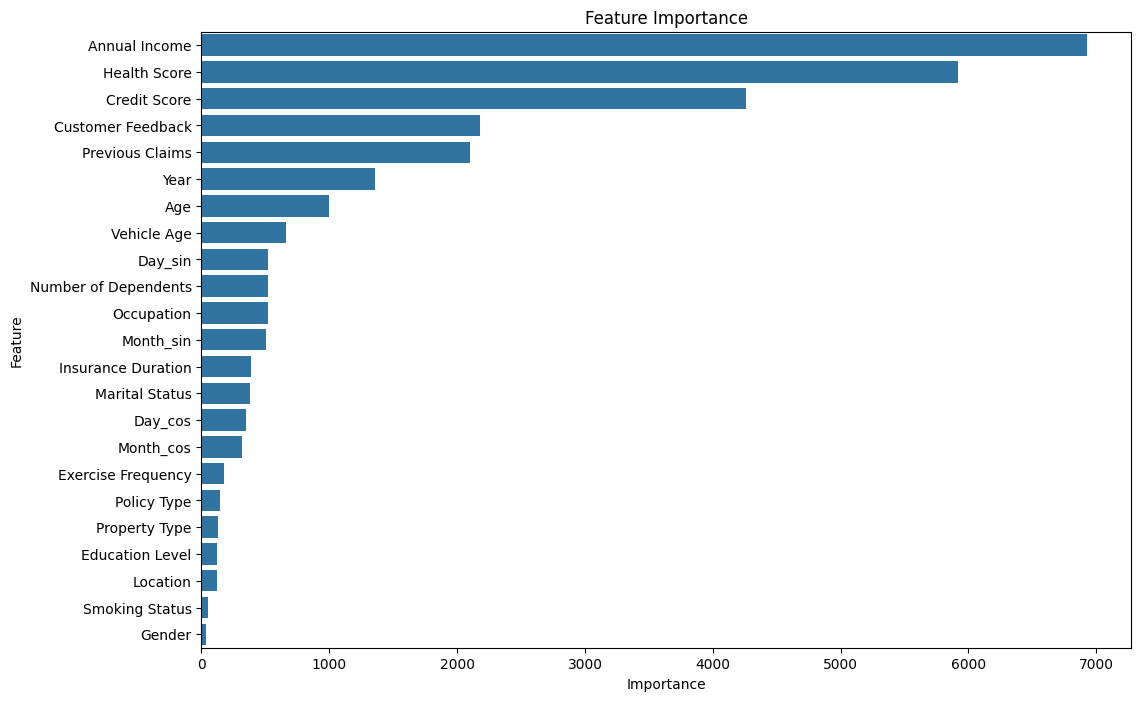

In [21]:
best_params = {'n_estimators': 700, 'learning_rate': 0.006002641114390338, 'num_leaves': 42, 'max_depth': 15, 'min_child_samples': 72, 
               'subsample': 0.7200344333898133, 'colsample_bytree': 0.6986521753741868, 'reg_alpha': 0.0013223748424590466, 
               'reg_lambda': 0.40630468090624405}

#Training LGBMRegressor Model - It is known for being fast and efficient in training, especially on large datasets.
best_model = LGBMRegressor(**best_params, verbose=-1, n_jobs=-1)
best_model.fit(X, np.log1p(y))

#Make predictions
test_preds = best_model.predict(test)
test_preds = np.expm1(test_preds)

sample_submission['Premium Amount'] = test_preds
sample_submission.to_csv('submission1.csv', index=False)

#Visualising the importance of each field of the dataset in determing the Premium Amount
importances = best_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()